In [139]:
# Initialize Otter
import otter
grader = otter.Notebook("lab2.ipynb")

In [140]:
import numpy as np
from resources.hashutils import *
import matplotlib.pyplot as plt
from resources.utils import *

---

<h1><center>SDSE Lab 2 <br>Solving optimization problems with <br> Gradient Descent and <br> Stochastic Gradient Descent </center></h1>

---

# Contents

**Part I**:  Estimating $\lambda$ for an exponential distribution
+ I-1) Sampling a dataset
+ I-2) Cost function
+ I-3) Analytical solution
	+ I-3.1) Compute $\lambda_*$
	+ I-3.2) Plot
	+ I-3.3) Variations due to uncertainty in the data
		+ I-3.3.1) Variations in $\mathcal{J}_1(\lambda;\mathcal{D})$ and $\lambda_*$
		+ I-3.3.2) Plot $\mathcal{J}_1(\lambda;\mathcal{D})$
		+ I-3.3.3) Histogram of $\lambda_*$
+ I-4) Gradient descent
	+ I-4.1) Compute $\mathcal{J}_1'(\lambda,\mathcal{D})$
	+ I-4.2) Plot $\mathcal{J}_1'$
	+ I-4.3) Code gradient descent
	+ I-4.4) Plot gradient descent
	+ I-4.5) Count evaluations of $\mathcal{J}_1'(\lambda;\mathcal{D})$

**Part II**: Estimating $\mu$ and $\sigma^2$ for a normal distribution
 
+ II-1) Cost function
+ II-2) Analytical solution
	+ II-2.1) Compute $\mu_*$ and $\sigma^2_*$
+ II-3) Gradient descent
	+ II-3.1) Compute the gradient
	+ II-3.2) 2D gradient descent
	+ II-3.3) Plot gradient descent
	+ II-3.4) Run this GD over a grid of initial conditions.
+ II-4) Stochastic gradient descent
	+ II-4.1) Code stochastic gradient descent

---

In this lab exercise we use gradient descent (GD) and stochastic gradient descent (SGD) to solve the maximum likelihood problem, which is an important problem in statistics. The details of maximum likelihood will be covered in the lecture on point estimation. Here we are only concerned with the numerical solution of the optimzation problem -- not its formulation or purpose.

# Problem statement

Suppose that we have a system that produces real-valued (scalar) measurements. The system is modeled as a random variable $Y$ with an unknown pdf $p_Y$. The dataset $\mathcal{D}$ consists of $N$ measurements iid sampled from $Y$.
\begin{equation*}
\mathcal{D} = \{ y_i \}_N \sim Y
\end{equation*}

Our goal is to use $\mathcal{D}$ to estimate a distribution $p$ that best approximates $p_Y$. Here we use the *maximum likelihood* technique, which solves the problem in two steps. The first step is to guess which family of distributions best fits $Y$. This can be done by looking at a histogram of the data, or based on expert opinion. 
The second step, given our choice, is to solve an optimization problem for the optimal values of the parameters. 

\begin{equation*}
\underset{\theta_1,...\theta_D}{\text{minimize}}\;  -\frac{1}{N}\sum_{i=1}^{N} \ln p(y_i;\theta_1,...\theta_D)  
\end{equation*}

Here, $p(y_i;\theta_1,...\theta_D)$ is the pdf of the selected family with parameters $\theta_1,...,\theta_D$, evaluated on the sample $y_i\in\mathcal{D}$. It is not important for this lab to understand the reasoning behind this formula. For now we regard it simply as a function to be minimized. We refer to this function as the *cost function* $\mathcal{J}(\theta_1,...\theta_D;\mathcal{D})$. 

\begin{equation*}
\mathcal{J}(\theta_1,...\theta_D;\mathcal{D}) = -\frac{1}{N}\sum_{i=1}^{N} \ln p(y_i;\theta_1,...\theta_D)  
\end{equation*}

This notation emphasize that we minimize $\mathcal{J}$ over the parameters $\theta_1,...,\theta_D$ with the dataset $\mathcal{D}$ held fixed. 


---

# **Part I:**  Estimating $\lambda$ for an exponential distribution

---

# I-1) Sampling a dataset

The method `draw_50_samples_from_I` returns an array of 50 floating point values that represent 50 iid measurements from a system. We pretend that we do not know the underlying process, but in fact the data was generated from an exponential distribution with $\lambda=10$. 

In [141]:
D = draw_50_samples_from_I()
N = len(D)

print(f"The dataset has {N} samples")

The dataset has 50 samples


Let's visualize the data. The top row in the figure below shows the data points arranged on a line. The bottom row shows a histogram of the data. 

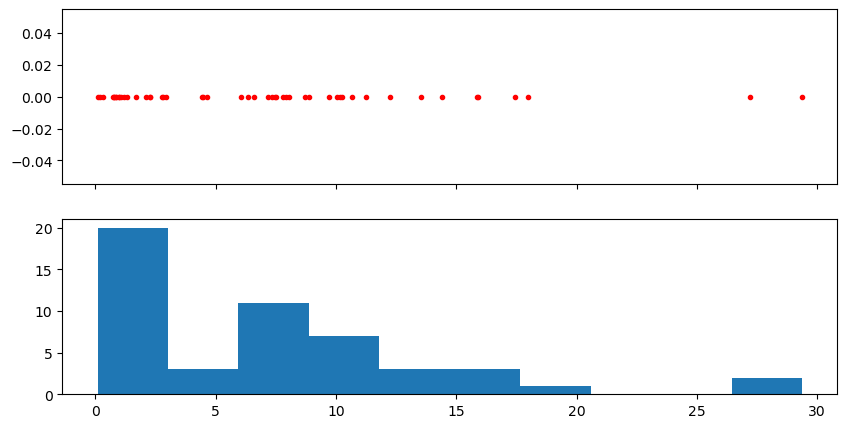

In [142]:
fig, ax = plt.subplots(figsize=(10,5),nrows=2,sharex=True)
ax[0].plot(D,np.zeros(N),'r.')
ax[1].hist(D);

From the histogram, and perhaps based on our understanding of the system, we postulate that $Y$ is exponentially distributed. 

\begin{equation*}
p(y;\lambda) = \lambda e^{-\lambda y}
\end{equation*}
$\lambda$ is unknown. We plug this formula into the expression for the cost function:
\begin{align*}
\mathcal{J}_1(\lambda;\mathcal{D}) &= -\frac{1}{N}\sum_{i=1}^{N} \ln p(y_i;\lambda)   \\
 &= -\frac{1}{N}\sum_{i=1}^{N} \ln\left( \lambda e^{-\lambda y} \right)  \\
 &= -\frac{1}{N}\sum_{i=1}^{N}\left( \ln(\lambda) -\lambda y \right)  \\
&=  - \ln\lambda +  \frac{\lambda}{N}\sum_{i=1}^N y_i
\end{align*}
We call this $\mathcal{J}_1(\lambda;\mathcal{D})$ (with subindex 1) to distinguish it from the cost function in part 2 of this lab. 
The expression is simplified by defining $\bar{y}$ as the mean of the samples in $\mathcal{D}$.
\begin{equation*}
\mathcal{J}_1(\lambda;\mathcal{D}) =  - \ln\lambda + \lambda \: \bar{y}
\end{equation*}

Next we will write code to find the value of $\lambda_*$ that minimizes $\mathcal{J}_1(\lambda;\mathcal{D})$. We will do this by both analytical and numerical means. 

## I-2) Cost function

Write a function that computes $\mathcal{J}_1(\lambda;\mathcal{D})$ for a given $\lambda$ and dataset $\mathcal{D}$. (This can be done with one line of code.)

**Hint**: NumPy aggregations. 

In [143]:
def curlyJ1(lmbda,D):
    return -np.log([lmbda])[0] + (lmbda*(sum(D)/N))

In [144]:
grader.check("I_2")

I_2 results: All test cases passed!

## I-3) Exact solution

The optimality conditions for this problem tell us that, if a solution $\lambda^*$ exists, then it must be a *stationary point* of $\mathcal{J}_1(\lambda;\mathcal{D})$, meaning one where the derivative is zero. That is, if $\lambda^*$ is a solution, then
\begin{equation*}
\mathcal{J}_1'(\lambda^*;\mathcal{D}) = 0
\end{equation*}
This does not mean that all stationary points are solutions. Some stationary points may be maxima instead of minima. Some may be local minima but not global minima. But if there is a small number of stationary points, then we can evaluate $\mathcal{J}_1(\lambda;\mathcal{D})$ on each one, and be assured that the one with the lowest value is the global solution. 

Our strategy for finding $\lambda^*$ therefore begins with finding all of the stationary points. That is, all of the values $\lambda_s$ that satisfy $\mathcal{J}_1'(\lambda_s,\mathcal{D}) = 0$. Solving this equation produces a *unique* stationary point:
\begin{equation*}
\lambda_s = 1/\bar{y}
\end{equation*}

Since there is only one, we conclude that it is $\lambda^*$.
\begin{equation*}
\lambda^* = 1/\bar{y}
\end{equation*}

### I-3.1) Compute $\lambda^*$

Write a function that computes $\lambda^*$ for a given $\mathcal{D}$. (This can be done in one line.)

In [145]:
def eval_lambda_star(D):
    return 1/(sum(D)/N)

In [146]:
grader.check("I_3_1")

I_3_1 results: All test cases passed!

### I-3.2) Plot

Plot the cost function $\mathcal{J}_1$ evaluated on logarithmically spaced points (NumPy's `logspace`) ranging from $10^{-2}$ to $10^{-0.5}$. Place a vertical line (matplotlib `axvline`) at $\lambda_*$.

Your plot should look like this:

<img src="resources/lambdastar.png" />

Text(0, 0.5, '$\\mathcal{J}_1(\\lambda)$')

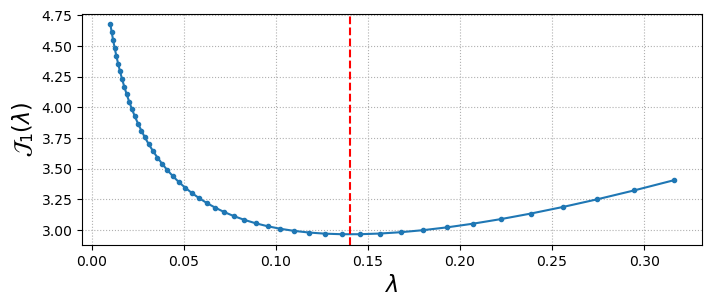

In [147]:
lmbdas = np.logspace(-2, -0.5, num=N)
J1s = [curlyJ1(lmbda, D) for lmbda in lmbdas]

fig = plt.figure(figsize=(8,3))
ax = plt.subplot()
ax.plot(lmbdas, J1s,'.-')
ax.axvline(eval_lambda_star(D),color='r',linestyle='--')
ax.grid(linestyle=':')
ax.set_xlabel('$\\lambda$',fontsize=16)
ax.set_ylabel('$\\mathcal{J}_1(\\lambda)$',fontsize=16)

### I-3.3) Variations due to uncertainty in the data

The computation of both the cost function $\mathcal{J}_1(\lambda;\mathcal{D})$ and the optimal value $\lambda^*$ were based on the randomly sampled dataset $\mathcal{D}$. Next we will see the effect that variations in $\mathcal{D}$ have on $\mathcal{J}_1(\lambda;\mathcal{D})$ and $\lambda^*$.

#### I-3.3.1) Variations in $\mathcal{J}_1(\lambda;\mathcal{D})$ and $\lambda^*$

Compute $\mathcal{J}_1(\lambda;\mathcal{D})$ and $\lambda^*$ for 300 independently samples datasets.

In [148]:
num_datasets = 300
Ds = draw_50_samples_from_I_300_times()
J1_samples = np.empty((num_datasets,lmbdas.shape[0]))
lambda_star_samples = np.empty(num_datasets)
for i in range(num_datasets):
    D = Ds[i,:]
    J1_samples[i,:] = curlyJ1(lmbdas, D)
    lambda_star_samples[i] = eval_lambda_star(D)

In [149]:
grader.check("I_3_3_1")

I_3_3_1 results: All test cases passed!

#### I-3.3.2) Plot $\mathcal{J}_1(\lambda;\mathcal{D})$

Plot the 300 versions of $\mathcal{J}_1(\lambda;\mathcal{D})$ on a single plot. Pass parameters `c='k'`,`linewidth=0.5`, and `alpha=0.1` to the `plot` function.


Your plot should look like this:

<img src="resources/lambdastar_stoch.png" />

Text(0, 0.5, '$\\mathcal{J}_1(\\lambda)$')

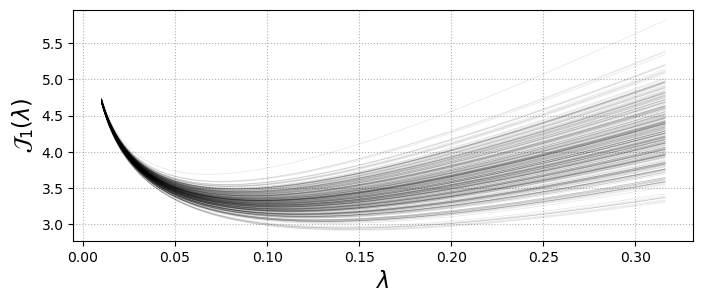

In [150]:
fig = plt.figure(figsize=(8,3))
ax = plt.subplot()
[ax.plot(lmbdas, J1_samples[s], c='k', linewidth=0.5, alpha=0.1)  for s in range(num_datasets)]
ax.grid(linestyle=':')
ax.set_xlabel('$\\lambda$',fontsize=16)
ax.set_ylabel('$\\mathcal{J}_1(\\lambda)$',fontsize=16)

#### I-3.3.3) Histogram of $\lambda^*$

Make a histogram of the 300 samples of $\lambda^*$. The histogram should have 50 bins. Draw a vertical line on it indicating the average of the values.

Your plot should look like this:

<img src="resources/lambdastar_hist.png" />

Text(0.5, 0, '$\\lambda^*$')

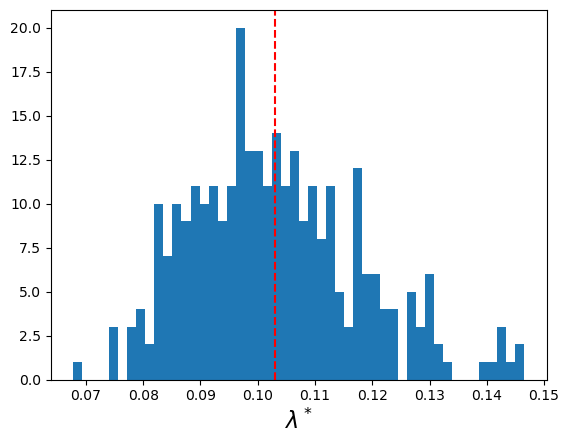

In [151]:
fig = plt.figure()
ax = plt.subplot()
ax.hist(lambda_star_samples, bins=50)
ax.axvline(np.mean(lambda_star_samples) ,color='r',linestyle='--')
ax.set_xlabel('$\\lambda^*$',fontsize=16)

Solving optimization problems is usually not this easy to do by hand. More often we must use a numerical method executed on a computer. There are many algorithms for doing this, and they divide roughly into two types: ones that use gradient information and ones that do not. Here we will demonstrate canonical examples of each of these types. 

## I-4 Solution with gradient descent

Gradient-based algorithms assume that we have at our disposal a method for evaluating the derivative (a.k.a. the gradient) of the cost function. Given this requirement, the procedure begins by making a guess $\lambda_0$. We call $\lambda_0$ the *initial condition* of the algorithm. If $\lambda_0$ happens to be a stationary point (ie. $\mathcal{J}_1'(\lambda_0;\mathcal{D})=0$), then the procedure terminates and returns $\lambda_0$. Otherwise it proceeds to compute $\lambda_1$ with
\begin{equation*}
\lambda_{1} = \lambda_{0} - \gamma \: \mathcal{J}_1'(\lambda_0;\mathcal{D}) 
\end{equation*}
Here $\gamma$ is a positive number called the *step size*. The reasoning behind this formula is that by taking steps in the direction of the *negative gradient*, the algorithm will eventually reach a local minimum. This is true so long as $\gamma$ is chosen correctly (not too big). The general formula for gradient descent is,
\begin{equation*}
\lambda_{k+1} = \lambda_{k} - \gamma \: \mathcal{J}_1'(\lambda_k;\mathcal{D}) \qquad k\in\{0,...,K-1\}
\end{equation*}
Here $K$ is the number of steps taken.
There are a couple enhancements to consider. 

1) We can stop the process once we are within a tolerance value of a stationary point. That is, if the gradient becomes less than a pre-determined value $\tau$:
\begin{equation*}
|\mathcal{J}_1'(\lambda_k;\mathcal{D})|<\tau
\end{equation*}
which is equivalent to 
\begin{equation*}
|\lambda_{k+1}-\lambda_k|<\gamma\tau
\end{equation*}

2) For our particular problem, it is important to ensure that $\lambda_{k+1}$ does not become negative, since $\mathcal{J}_1'(\lambda_{k+1};\mathcal{D})$ would not be defined. To prevent this we can use $\lambda_{k+1} =\lambda_k/2$ whenever the standard formula produces a negative value.

In this lab exercise we will implement the simple version of gradient descent *without these two enhancements*. 

We will need a function that computes the gradient of $\mathcal{J}_1$. 
\begin{equation*}
\mathcal{J}_1'(\lambda;\mathcal{D}) =  - \frac{1}{\lambda} +  \bar{y}
\end{equation*}


### I-4.1) Compute $\mathcal{J}_1'(\lambda,\mathcal{D})$

Write a function that computes $\mathcal{J}_1'(\lambda,\mathcal{D})$ for a given $\lambda$ and $\mathcal{D}$. (This can be done with one line of code.)


In [152]:
def curlyJ1prime(lmbda,D):
    return (-1/lmbda) + np.mean(D)

In [153]:
grader.check("I_4_1")

I_4_1 results: All test cases passed!

### I-4.2) Plot $\mathcal{J}_1'$

Plot the gradient $\mathcal{J}'_1$ evaluated on logarithmically spaced points (numpy `logspace`) ranging from $10^{-2}$ to $10^{-0.5}$. Place a vertical line (matplotlib `axvline`) at $\lambda^*$.

Your plot should look like this:

<img src="resources/jprime.png" />

Text(0, 0.5, "$\\mathcal{J}'_1(\\lambda)$")

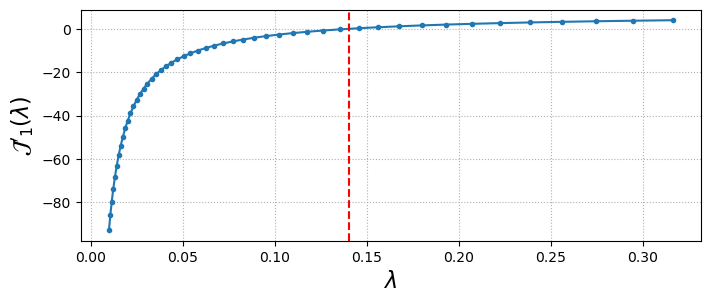

In [154]:
D = draw_50_samples_from_I()

lmbdas = np.logspace(-2,-0.5)
J1ps = curlyJ1prime(lmbdas, D)
fig = plt.figure(figsize=(8,3))
ax = plt.subplot()
ax.plot(lmbdas, J1ps,'.-')
ax.axvline(eval_lambda_star(D), color='r', linestyle='--')
ax.grid(linestyle=':')
ax.set_xlabel('$\\lambda$',fontsize=16)
ax.set_ylabel("$\\mathcal{J}'_1(\\lambda)$",fontsize=16)

### I-4.3) Code gradient descent

Write a function called `GD_1D` that takes arguments 
+ `Jprime` ... a function that evaluates the derivative of the cost function. Example: `GD_1D(curlyJprime,D)`
+ `D` ... the dataset
+ `lambda_init` ... the initial condition for gradient descent

Use $\gamma=0.01$ and $K=10$.
The function should return a numpy array of length $K$, with `lambda_init` in the zeroth position.

In [155]:
def GD_1D(Jprime,D,lmbda_init=0.3):
    gamma=0.01
    K=10
    lmbdas = np.empty(K)
    lmbdas[0] = lmbda_init
    for i in range (1, K):
        lmbdas[i] = lmbdas[i-1] - (gamma * Jprime(lmbdas[i-1], D))
    return lmbdas

In [156]:
lmbdas_gd = GD_1D(curlyJ1prime,D)

In [157]:
grader.check("I_4_3")

I_4_3 results: All test cases passed!

### I-4.4) Plot gradient descent

Create a plot showing the convergence of $\{\lambda_k\}_K$ (from gradient descent) to $\lambda_*$


Your plot should look like this:

<img src="resources/lambdaconv.png" />


Text(0, 0.5, '$\\lambda_k$')

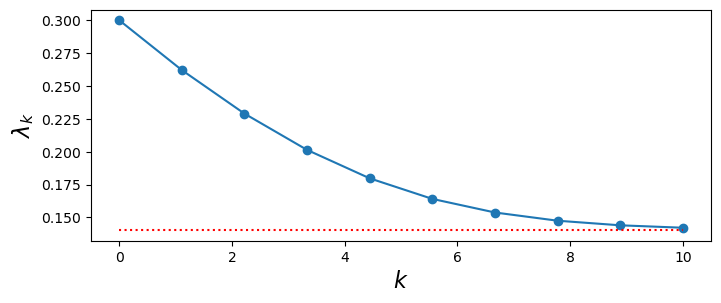

In [158]:
lmbdas_gd = GD_1D(curlyJ1prime,D)
K_gd = len(lmbdas_gd)

fig = plt.figure(figsize=(8,3))
ax = plt.subplot()
ax.plot(np.linspace(0, K_gd, 10), lmbdas_gd,'-o')
ax.hlines(eval_lambda_star(D),0,K_gd,color='r',linestyles=':')
ax.set_xlabel('$k$',fontsize=16)
ax.set_ylabel('$\\lambda_k$',fontsize=16)

### I-4.5) Count evaluations of $\mathcal{J}_1'(\lambda;\mathcal{D})$


**Hint**: `np.where`

How many evaluations of $\mathcal{J}_1'(\lambda;\mathcal{D})$ were needed for gradient descent to reach within 0.01 of $\lambda^*$?

In [159]:
def count_J1prime_evals(lmbdas_gd,lambda_star):
    return sum(np.where(lmbdas_gd <= lambda_star + 0.01, 0, 1))

In [160]:
grader.check("I_4_5")

I_4_5 results: All test cases passed!

---

# **Part II:** Estimating $\mu$ and $\sigma^2$ for a normal distribution

---

We now repeat the exercise with a different system. 

In [161]:
D = draw_50_samples_from_II()
N = D.shape[0]
N

50

Here is a scatter plot and histogram of the data. 

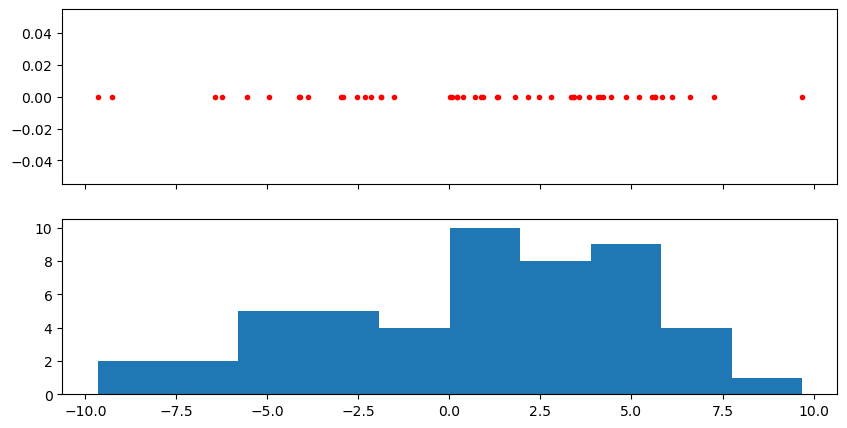

In [162]:
fig, ax = plt.subplots(figsize=(10,5),nrows=2,sharex=True)
ax[0].plot(D,np.zeros(N),'r.')
ax[1].hist(D);

The plot clearly shows that the data cannot be exponentially distributed since it includes negative value. We decide too use a Gaussian distribution.  The pdf for the Gaussian distribution is:

\begin{equation*}
p(y;\mu,\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left( -\frac{(y-\mu)^2}{2\sigma^2}   \right)
\end{equation*}

Plugging this into the maximum likelihood cost function and doing some simple algebra we obtain:

\begin{equation*}
\mathcal{J}_2(\mu,\sigma^2;\mathcal{D}) = 
\frac{1}{2}\ln(2\pi\sigma^2)
+\frac{1}{2N\sigma^2}\sum_{i=1}^N (y_i-\mu)^2 
\end{equation*}


## II-1) Cost function

Write a function that computes $\mathcal{J}_2(\mu,\sigma^2;\mathcal{D})$ for given $\mu$, $\sigma^2$, and dataset $\mathcal{D}$. (This can be done in one line of code.)


In [163]:
def curlyJ2(mu,sigma2,D):
    return (0.5 * np.log(2 * np.pi * sigma2)) + (1 / (2 * len(D) * sigma2)) * sum((y - mu)**2 for y in D) 

In [164]:
grader.check("II_1")

II_1 results: All test cases passed!

## II-2) Exact solution

We can use algebra to find a solution, just as we did with the exponential distribution, by equating the derivative of the cost function to zero. Now however, because our search space is two-dimensional $(\mu,\sigma^2)$, we must work with a vector *gradient* instead of a scalar *derivative*. 

You can verify that the partial derivatives of $\mathcal{J}_2(\mu,\sigma^2;\mathcal{D})$ are:

\begin{align*}
\frac{\partial \mathcal{J}_2}{\partial \mu} &= \frac{\mu-\bar{y}}{\sigma^2} \\ 
\frac{\partial \mathcal{J}_2}{\partial \sigma^2} &= \frac{1}{2\sigma^2} \left(1 -	
\frac{1}{N\sigma^2}\sum_{i=1}^N \left( y_i-\mu  \right)^2 \right)
\end{align*}

Equating $\frac{\partial \mathcal{J}_2}{\partial \mu}$ and $\frac{\partial \mathcal{J}_2}{\partial \sigma^2}$ to zero we get two equations for stationary $\mu$ and $\sigma^2$. From these we can find the *unique* stationary point, which is also the solution to the optimization problem:

\begin{align*}
\mu_* &= \bar{y} \\
\sigma^2_* &= \frac{1}{N}\sum_{i=1}^{N}(y_i-\bar{y})^2
\end{align*}



### II-2.1) Compute $\mu_*$ and $\sigma^2_*$

Write a function that computes $\mu_*$ and $\sigma^2_*$ for a given $\mathcal{D}$.

In [165]:
def eval_mu_sigma2_star(D):
    mu_star = np.mean(D)
    sigma2_star = (1/len(D)) * np.sum((y - mu_star)**2 for y in D)
    return mu_star, sigma2_star

In [166]:
mu_star, sigma2_star = eval_mu_sigma2_star(D)

/var/folders/k6/qhkjmmkx2jz86kx07zfbrp8m0000gn/T/ipykernel_37753/2544666127.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sigma2_star = (1/len(D)) * np.sum((y - mu_star)**2 for y in D)


In [167]:
grader.check("II_2_1")

II_2_1 results: All test cases passed!

## II-3) Gradient descent


### II-3.1) Compute the gradient

Write a function that computes the gradient $\left(\frac{\partial \mathcal{J}_2}{\partial \mu},\frac{\partial \mathcal{J}_2}{\partial \sigma^2}\right)$ as a function of $\mu$, $\sigma^2$, and $\mathcal{D}$.

In [168]:
def gradient(mu,sigma2,D):
    N = len(D)
    partialMu = (mu - np.mean(D)) / sigma2
    partialSigma2 = (1 / (2 * sigma2)) * (1 - (1 / (N * sigma2)) * sum((y - mu)**2 for y in D))
    return partialMu, partialSigma2

In [169]:
dmu,dsigma2 = gradient(2,2,D)

In [170]:
grader.check("II_3_1")

II_3_1 results: All test cases passed!

### II-3.2) 2D gradient descent

Write the gradient descent algorithm for this 2D case. The code should be very similar to the 1D function.

In [171]:
def GD_2D(GRAD,D,mu_init,sigma2_init,num_epochs):
    gamma_mu, gamma_sigma2 = 1.5, 20
    N = D.shape[0]
    numsteps = num_epochs*N   # each epoch is a sweep though N samples in the dataset
    mu = np.empty(numsteps)
    mu[0] = mu_init
    sigma2 = np.empty(numsteps)
    sigma2[0] = sigma2_init
    for k in range(numsteps - 1):
        delmu, delsigma2 = GRAD(mu[k],sigma2[k],D)
        mu[k+1] = mu[k] - gamma_mu * delmu
        sigma2[k+1] = sigma2[k] - gamma_sigma2 * delsigma2
    return mu, sigma2

In [172]:
mu_gd, sigma2_gd = GD_2D(gradient,D,mu_init=0.5,sigma2_init=10,num_epochs=2)

In [173]:
grader.check("II_3_2")

II_3_2 results: All test cases passed!

### II-3.3) Plot gradient descent

Your plot should look like this:

<img src="resources/gd.png" />


/var/folders/k6/qhkjmmkx2jz86kx07zfbrp8m0000gn/T/ipykernel_37753/2544666127.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sigma2_star = (1/len(D)) * np.sum((y - mu_star)**2 for y in D)


Text(0, 0.5, '$\\sigma^2_k$')

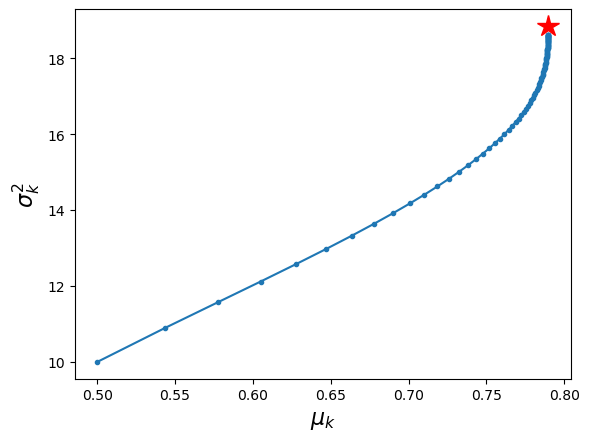

In [174]:
mu_gd, sigma2_gd = GD_2D(gradient,D,mu_init=0.5,sigma2_init=10,num_epochs=2)
mu_star, sigma2_star = eval_mu_sigma2_star(D)

fig, ax = plt.subplots()
ax.plot(mu_gd,sigma2_gd,'.-')
ax.plot(mu_star,sigma2_star,'r*',markersize=16)
ax.set_xlabel('$\\mu_k$',fontsize=16)
ax.set_ylabel('$\\sigma^2_k$',fontsize=16)

### II-3.4) Run this GD over a grid of initial conditions.

The next cell runs gradient descent over a grid of initial conditions in the $(\mu,\sigma^2)$ plane. Notice that in every case the trajectory converges toward the true solution of the optimization problem $(\mu_*,\sigma^2_*)$, shown as a red star in the first plot. 

/var/folders/k6/qhkjmmkx2jz86kx07zfbrp8m0000gn/T/ipykernel_37753/2544666127.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sigma2_star = (1/len(D)) * np.sum((y - mu_star)**2 for y in D)


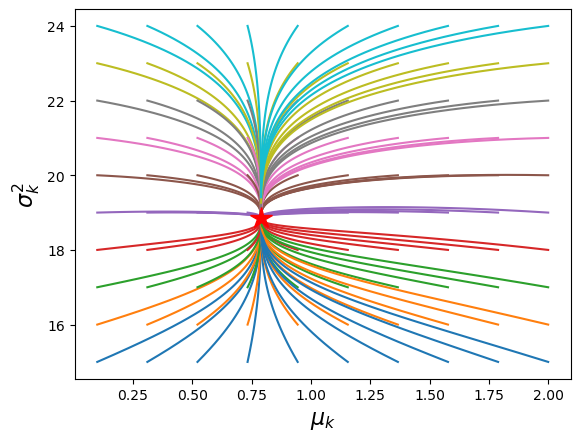

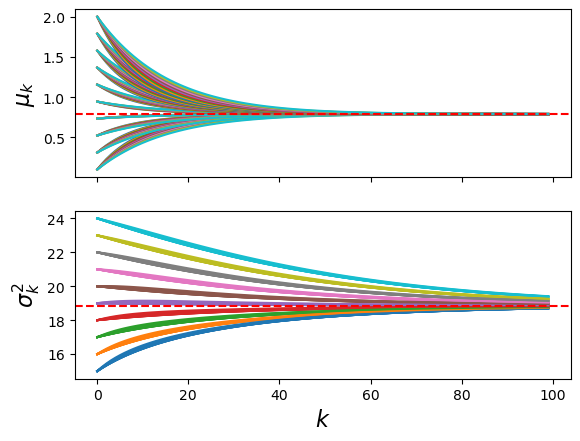

In [175]:
mu_star, sigma2_star = eval_mu_sigma2_star(D)

mu_range = np.linspace(0.1,2,10)
sigma2_range = np.arange(15,25)

_, ax1 = plt.subplots()
ax1.set_xlabel('$\\mu_k$',fontsize=16)
ax1.set_ylabel('$\\sigma^2_k$',fontsize=16)

_, ax2 = plt.subplots(nrows=2,sharex=True)
ax2[0].set_ylabel('$\\mu_k$',fontsize=16)


ax2[1].set_ylabel('$\\sigma^2_k$',fontsize=16)
ax2[1].set_xlabel('$k$',fontsize=16)

for i, mu_init in enumerate(mu_range):
    for j, sigma2_init in enumerate(sigma2_range):
        mu_gd, sigma2_gd = GD_2D(gradient,D,mu_init=mu_init,sigma2_init=sigma2_init,num_epochs=2)
        ax1.plot(mu_gd,sigma2_gd)
        ax2[0].plot(mu_gd)
        ax2[1].plot(sigma2_gd)

ax1.plot(mu_star,sigma2_star,'r*',markersize=16)
ax2[0].axhline(mu_star,0,100,color='r',linestyle='--')
ax2[1].axhline(sigma2_star,0,100,color='r',linestyle='--')


## II-4) Stochastic gradient descent

Recall the formula for the partial derivatives of $\mathcal{J}_2$. It can be written as:

\begin{align*}
\frac{\partial \mathcal{J}_2}{\partial \mu} &= \frac{1}{\sigma^2} \left( \mu - \frac{1}{N}\sum_{y_i\in\mathcal{D}} y_i \right) \\ 
\frac{\partial \mathcal{J}_2}{\partial \sigma^2} &= \frac{1}{2\sigma^2} \left(1 -	
\frac{1}{\sigma^2}\frac{1}{N}\sum_{y_i\in\mathcal{D}} \left( y_i-\mu  \right)^2 \right)
\end{align*}

Notice that both of these involve a sum over the dataset $\mathcal{D}$. While $\sum_{y_i\in\mathcal{D}} y_i$ can be pre-computed, $\sum_{y_i\in\mathcal{D}} \left( y_i-\mu  \right)^2$ is inextricable linked to $\mu$, and must therefore be re-computed at each step of gradient descent. This can be very time-consuming when $N$ is large. 

Stochastic gradient descent is the simple idea of approximating the gradient based on a sub-sample of the dataset $\mathcal{D}$, which we call a **batch** $\mathcal{B}$.

\begin{align*}
\frac{\partial \mathcal{J}_2}{\partial \mu} &\approx \frac{1}{\sigma^2} \left( \mu - \frac{1}{|\mathcal{B}|}\sum_{y_i\in\mathcal{B}} y_i \right) \\ 
\frac{\partial \mathcal{J}_2}{\partial \sigma^2} &\approx \frac{1}{2\sigma^2} \left(1 -	
\frac{1}{\sigma^2}\frac{1}{|\mathcal{B}|}\sum_{y_i\in\mathcal{B}} \left( y_i-\mu  \right)^2 \right)
\end{align*}
Here $|\mathcal{B}|$ is the number of samples in the batch.
Batches are obtained by splitting the dataset into equal parts. We will test SGD with batches of size 5. 



### II-4.1) Code stochastic gradient descent

Next we will code stochastic gradient descent. The code is very similar to `GD_2D` with a few exceptions to note:

1) It should begin by splitting $\mathcal{D}$ into batches of size `batch_size`. The code below uses the `reshape` method to do this. Understand how it works, and then you can copy it directly into your `SGD` method.

``` python
N = D.shape[0]
num_batches = int(N/batch_size)
batches = D.reshape((num_batches,batch_size))
```

2) Each step in the iteration is based on a new batch. After reaching the last batch, you should begin again with the first. In other words, at the `k`'th step you should use the `(k % num_batches)`'th batch

In [176]:
def SGD(GRAD,D,batch_size,mu_init,sigma2_init,num_epochs):

    # Split D into batches (see item 1 above)
    N = D.shape[0]
    num_batches = int(N / batch_size)
    batches = D.reshape((num_batches, batch_size))

    # Initialization (same as GD_2D)
    gamma_mu, gamma_sigma2 = 1,20
    numsteps = num_epochs*num_batches      # each epoch is a sweep though all of the batches in the dataset
    mu = np.empty(numsteps)
    mu[0] = mu_init
    sigma2 = np.empty(numsteps)
    sigma2[0] = sigma2_init

    for k in range(numsteps-1):

        # Choose the batch (see item 2 above)
        B = batches[k % num_batches]

        # Same as GD_2D
        delmu, delsigma2 = GRAD(mu[k], sigma2[k], B)
        mu[k+1] = mu[k] - gamma_mu * delmu
        sigma2[k+1] = sigma2[k] - gamma_sigma2 * delsigma2
        
    return mu, sigma2

In [177]:
mu_gd, sigma2_gd = SGD(gradient,D,batch_size=5,mu_init=0.5,sigma2_init=10,num_epochs=10)

In [178]:
grader.check("II_4_1")

II_4_1 results: All test cases passed!

### SGD trajectories

The next cell repeats the plots we made for gradient descent, but now using stochastic gradient descent. Notice that the trajectories are much more jagged, and they do not actually converge to the true solution. In this sense, stochastic gradient descent is *not* a good algorithm for solving optimization problems. However it is popular in machine learning applications because a) it is faster than GD for large datasets, and b) approximate convergence (as opposed to exact convergence) is often good enough. 

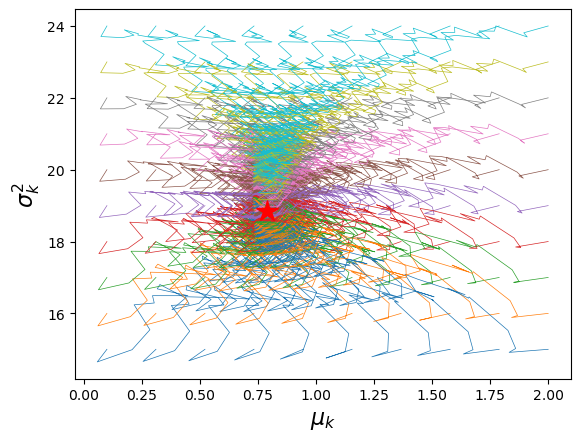

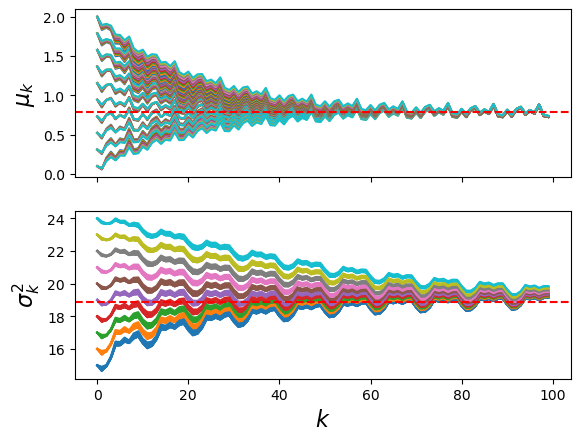

In [179]:
mu_range = np.linspace(0.1,2,10)
sigma2_range = np.arange(15,25)
batch_size = 5

_, ax1 = plt.subplots()
ax1.set_xlabel('$\\mu_k$',fontsize=16)
ax1.set_ylabel('$\\sigma^2_k$',fontsize=16)

_, ax2 = plt.subplots(nrows=2,sharex=True)
ax2[0].set_ylabel('$\\mu_k$',fontsize=16)
ax2[1].set_ylabel('$\\sigma^2_k$',fontsize=16)
ax2[1].set_xlabel('$k$',fontsize=16)

for i, mu_init in enumerate(mu_range):
    for j, sigma2_init in enumerate(sigma2_range):
        mu_gd, sigma2_gd = SGD(gradient,D,batch_size,mu_init=mu_init,sigma2_init=sigma2_init,num_epochs=10)
        ax1.plot(mu_gd,sigma2_gd,linewidth=0.5)
        ax2[0].plot(mu_gd)
        ax2[1].plot(sigma2_gd)

ax1.plot(mu_star,sigma2_star,'r*',markersize=16)
ax2[0].axhline(mu_star,0,100,color='r',linestyle='--')
ax2[1].axhline(sigma2_star,0,100,color='r',linestyle='--')

### The effect of batch size

The plot below illustrates SGD with different batch sizes ranging from 1 (pure SGD) to 50 (pure gradient descent, since $N=50$). The plot shows the convergence of the algorithm to the solution, when starting from a common initial condition. The x-axis is the number of samples processed. A dot marker is placed at each SGD step. With a batch size of 50, fewer steps are taken, but each step is of high quality, leading to a smoother but slower convergence. With a batch size of 1 (pure SGD), approximate convergence to the solution is quick, but noisy, and the algorithm never settles down. We can see that a good approach might be to start with small batches, in order to get quick initial convergence, and then increase the batch size in order to zero in on the solution. Indeed, this is often done. 

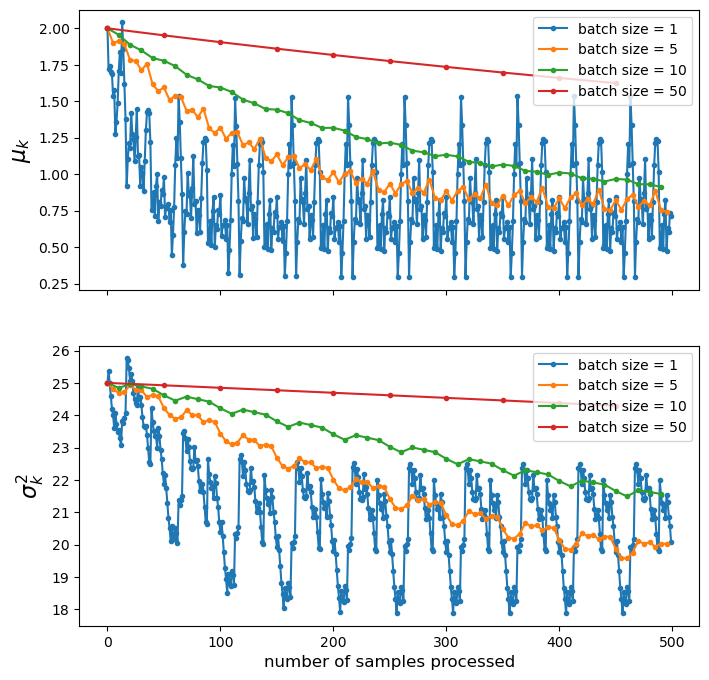

In [180]:
_, ax = plt.subplots(figsize=(8,8),nrows=2,sharex=True)
ax[0].set_ylabel('$\\mu_k$',fontsize=16)
ax[1].set_ylabel('$\\sigma^2_k$',fontsize=16)
ax[1].set_xlabel('number of samples processed',fontsize=12)

num_epochs=10
batch_sizes = [1,5,10,50]

for i, batch_size in enumerate(batch_sizes):
    mu_gd, sigma2_gd = SGD(gradient,D,batch_size=batch_size,mu_init=2.0,sigma2_init=25,num_epochs=num_epochs)
    x = np.arange(0,D.shape[0]*num_epochs,batch_size)
    ax[0].plot(x,mu_gd,marker='.',label=f'batch size = {batch_size}')
    ax[1].plot(x,sigma2_gd,marker='.',label=f'batch size = {batch_size}')

ax[0].legend()
ax[1].legend();

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [181]:
grader.check_all()

II_1 results: All test cases passed!

II_2_1 results: All test cases passed!

II_3_1 results: All test cases passed!

II_3_2 results: All test cases passed!

II_4_1 results: All test cases passed!

I_2 results: All test cases passed!

I_3_1 results: All test cases passed!

I_3_3_1 results: All test cases passed!

I_4_1 results: All test cases passed!

I_4_3 results: All test cases passed!

I_4_5 results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

Make sure you submit the .zip file to Gradescope.

In [182]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False)